In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

**Importamos las librerias necesarias**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import skew, kurtosis

### Estilos de visualización


In [34]:
# Estilos de visualizacion
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Cargar datasets

In [5]:
# Cargamos el dataset
data_dir = "/kaggle/input/child-mind-institute-problematic-internet-use/"

In [35]:
train = pd.read_csv(f"{data_dir}/train.csv")
test = pd.read_csv(f"{data_dir}/test.csv")
data_dict = pd.read_csv(f"{data_dir}/data_dictionary.csv")

### Mostramos informacion del dataset

In [36]:
# Mostramos informacion basica
print("Train Set Info:")
train.info()
print("\nTrain Set Description:")
print(train.describe())

Train Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 

### Checamos por valores faltantes

In [37]:
# Buscamos valores faltantes
print("\nMissing Values in Train Set:")
missing = train.isnull().sum()
print(missing[missing > 0])


Missing Values in Train Set:
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 78, dtype: int64


<Axes: title={'center': 'Missing Data Percentage'}>

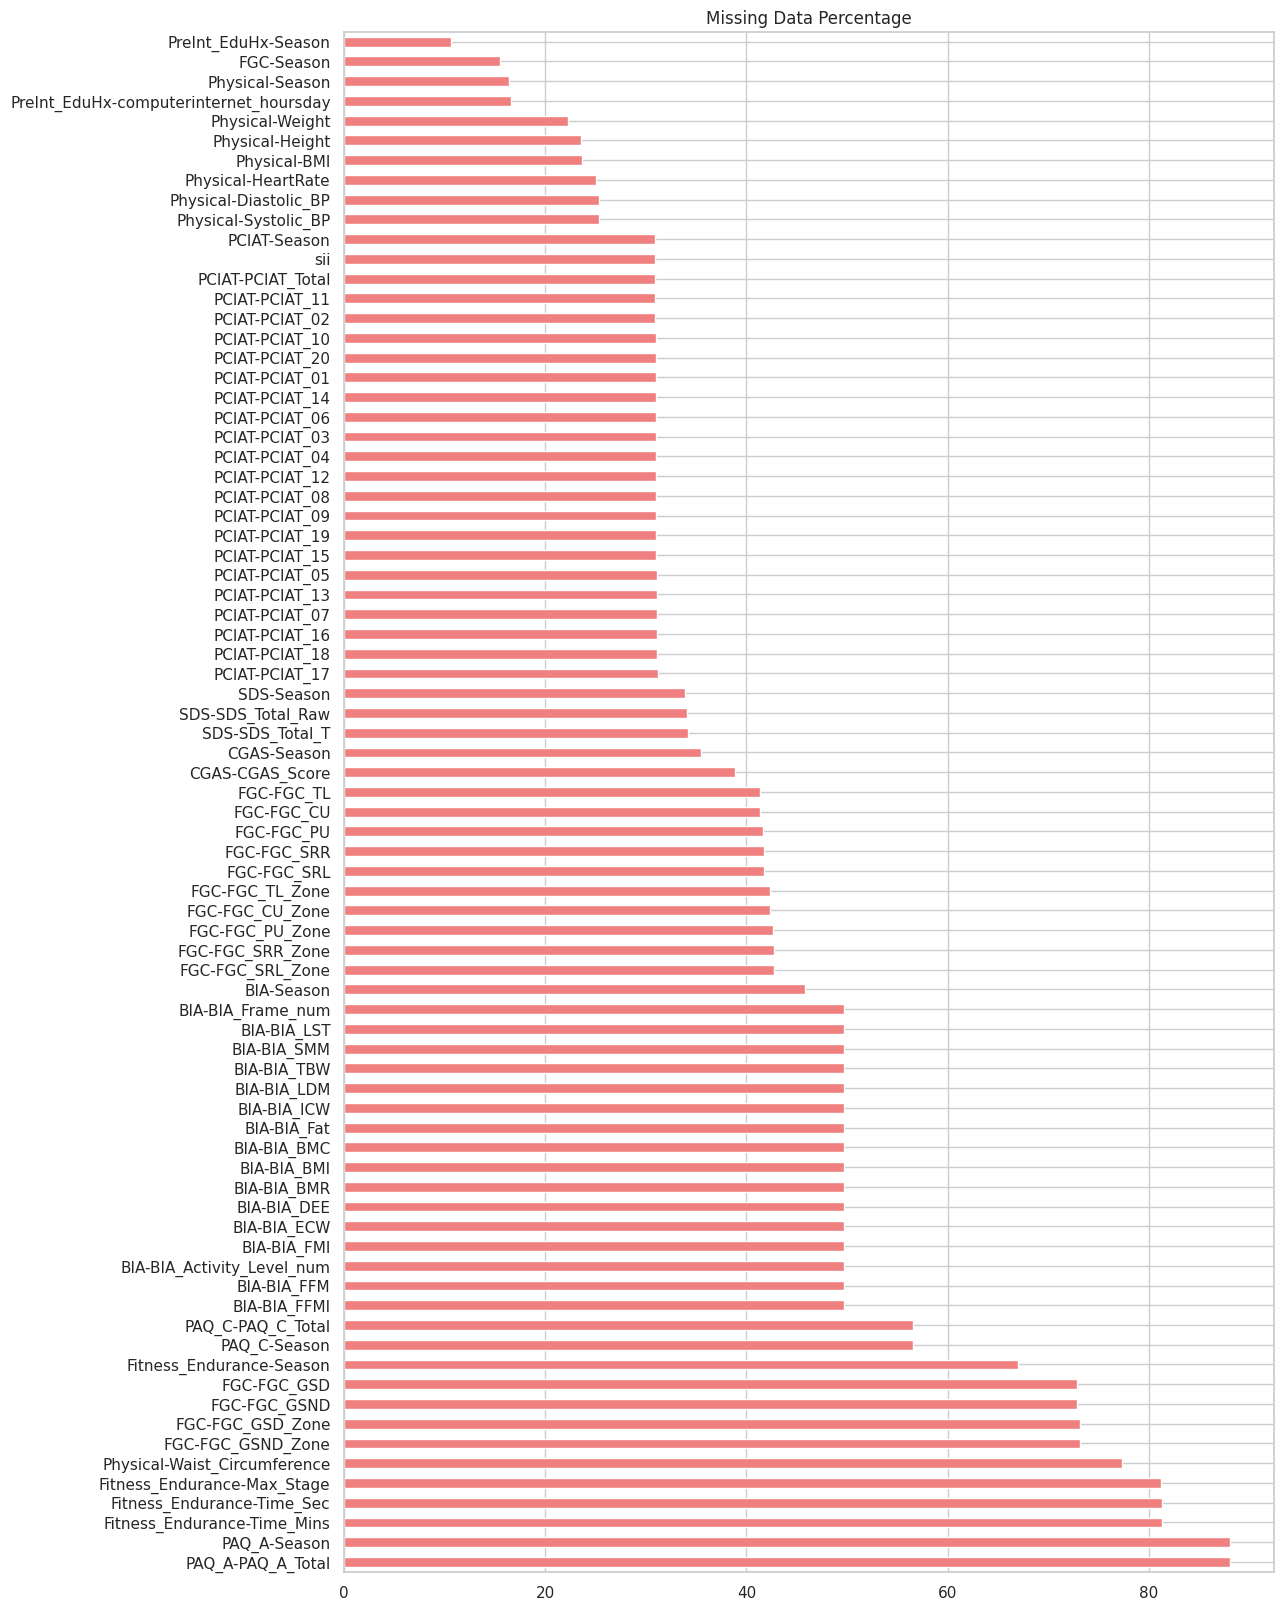

In [46]:
# Calculamos el porcentaje de valores faltantes
missing_data = train.isnull().mean() * 100
missing_data = missing_data[missing_data > 0]  # Solo mostramos las columnas con datos faltantes
missing_data.sort_values(ascending=False, inplace=True)

missing_data.plot(kind='barh', figsize=(12, 20), color='lightcoral', title='Missing Data Percentage')


# Análisis de datos faltantes

## Resumen del conjunto de datos
- **Total de entradas**: 3960
- **Total de columnas**: 82
- **Columnas sin valores faltantes**:
- Datos demográficos básicos (p. ej., `Basic_Demos-Age`, `Basic_Demos-Sex`)

## Observaciones clave del gráfico de datos faltantes

### Proporciones altas de valores faltantes
1. **Columnas de resistencia física**:
- Las columnas como `Fitness_Endurance-Max_Stage`, `Fitness_Endurance-Time_Mins` y `Fitness_Endurance-Time_Sec` muestran más del **80 %** de datos faltantes, lo que sugiere que pueden no ser útiles para el análisis.

2. **Columnas FGC**:
- En columnas como `FGC-FGC_GSND` y `FGC-FGC_GSD` faltan alrededor de un **70-80%** de datos, lo que indica un posible problema con la recopilación o la relevancia de los datos.

3. **Columnas BIA (Análisis de impedancia bioeléctrica)**:
- Muchos campos relacionados con BIA presentan una gran cantidad de datos faltantes, generalmente en el rango del **50-80%**.

4. **PAQ (Cuestionarios de actividad física)**:
- Las columnas `PAQ_A` tienen valores particularmente bajos, menos del **12%**, lo que genera inquietudes sobre su viabilidad para el análisis.

### Columnas con valores faltantes mínimos
- Las columnas como `Basic_Demos-Age`, `Basic_Demos-Sex` y `CGAS-CGAS_Score` están completamente llenas y se pueden usar de manera confiable para el análisis sin modificaciones.

## Como manejaremos valores faltantes

1. **Eliminar columnas no críticas**:
- Consideraremos eliminar columnas con datos faltantes excesivos si no contribuyen significativamente al análisis.

- 1. **Columna ID**:
   - `id`: No aporta información útil para el modelo predictivo, ya que es solo un identificador.

- 2. **Columnas con Alto Porcentaje de Missing Values**:
   - `Physical-Waist_Circumference` (898 non-null): Más del 75% de los datos son inexistentes.
   - `Fitness_Endurance` (e.g., `Fitness_Endurance-Max_Stage`, `Fitness_Endurance-Time_Mins`, etc.): Un 80% o más de valores faltantes.
   - `BIA` Columns: Como `BIA-BIA_BMC`, `BIA-BIA_FFM`, etc., con una gran cantidad de valores nulos.

- 3. **Columnas Redundantes o Irrelevantes**:
   - Columnas de autoevaluación que no estén claramente relacionadas con la actividad física o el uso problemático de Internet.
   - Cualquier columna categórica con demasiadas categorías que no aporten información relevante.


2. **Estrategias de imputación**:
- Para columnas significativas con valores faltantes, aplique:
- **Imputación de media/mediana** para campos numéricos.
- **Imputación de moda** para campos categóricos.
- Se pueden aplicar métodos más avanzados como **Imputación KNN** para la imputación.

3. **Investigar relaciones**:
- Examine las correlaciones entre los valores faltantes en diferentes columnas para comprender las posibles razones detrás de la falta de valores.

4. **Documentar decisiones**:
- Mantenga registros detallados de las decisiones relacionadas con el manejo de los datos faltantes para lograr transparencia y reproducibilidad.

5. **Reevaluación**:
- Después de abordar los valores faltantes, vuelva a evaluar el conjunto de datos para detectar los valores faltantes restantes y evalúe su impacto en un análisis posterior.


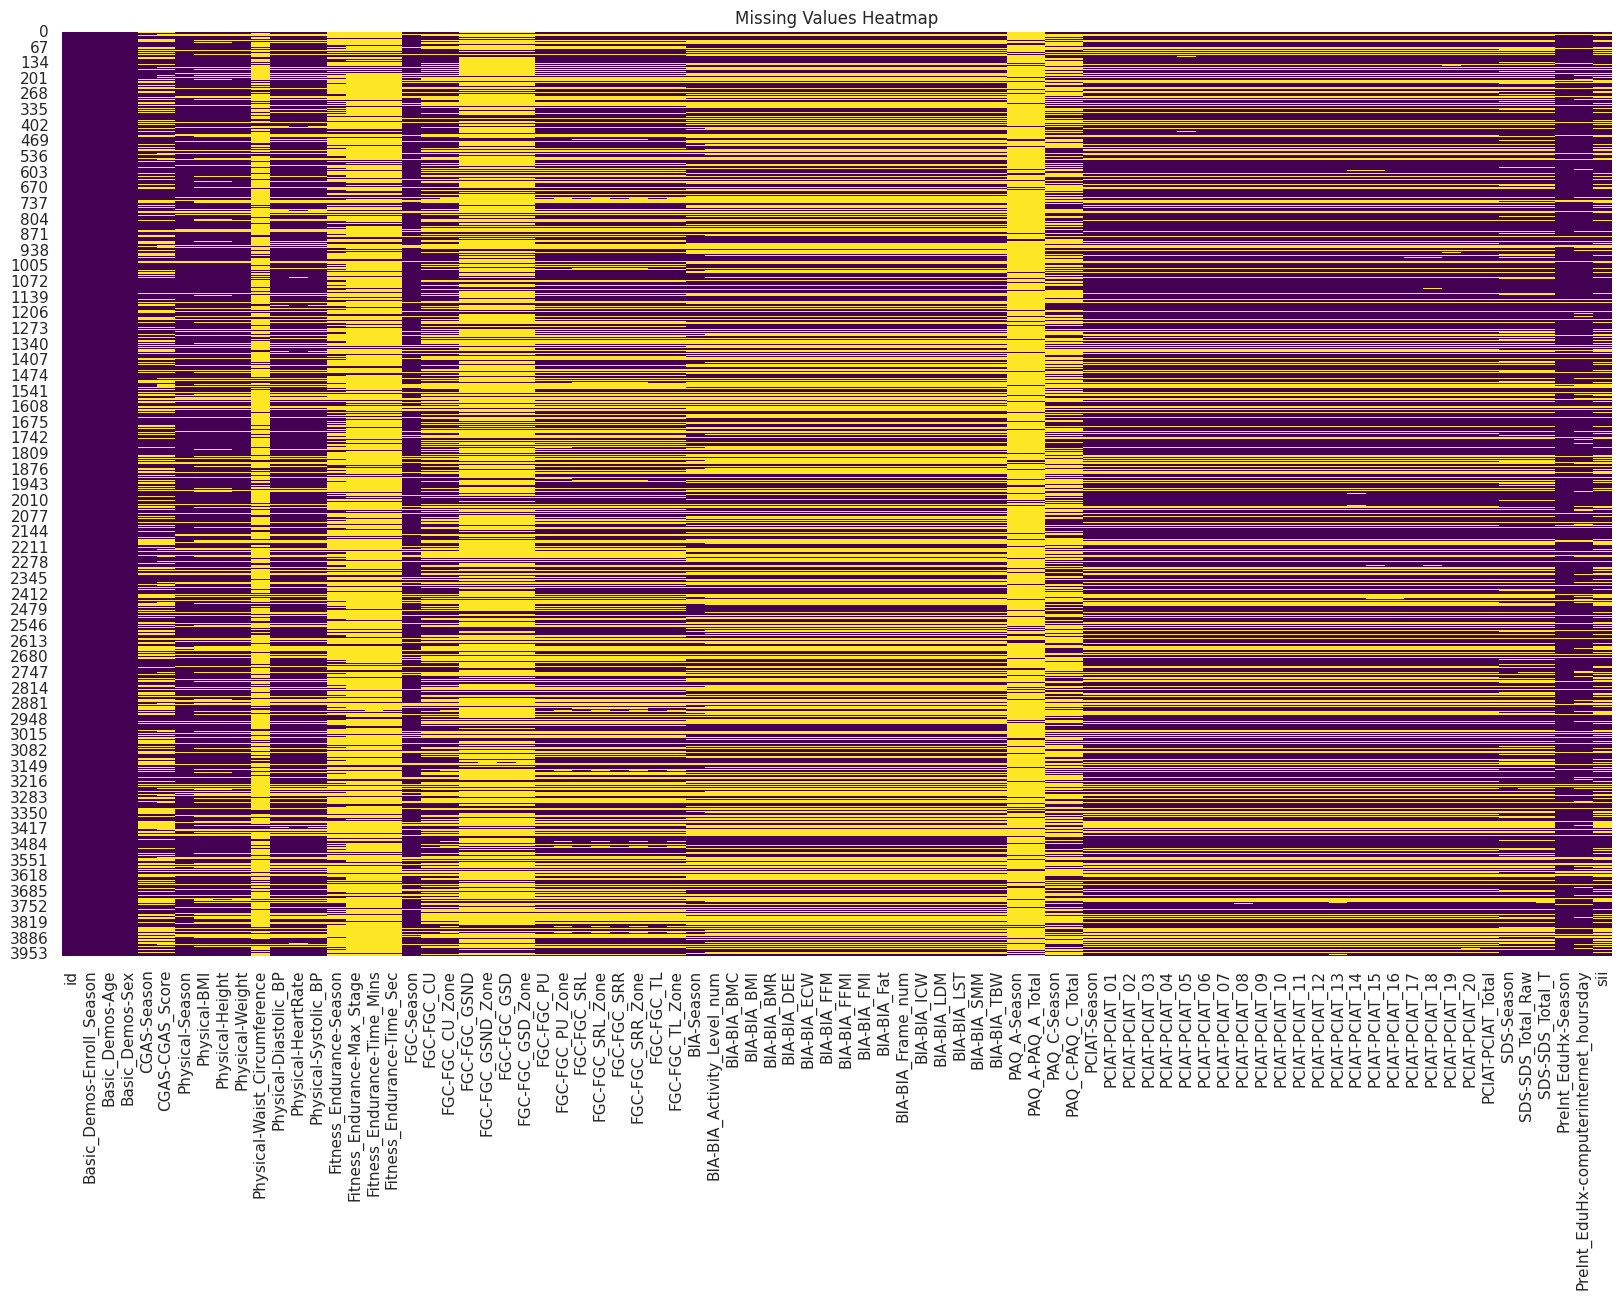

In [42]:
# Visualize missing values using a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

## Al notar la cantidad de valores cambiamos el analsis para facilitar la legibilidad de los datos mostrados

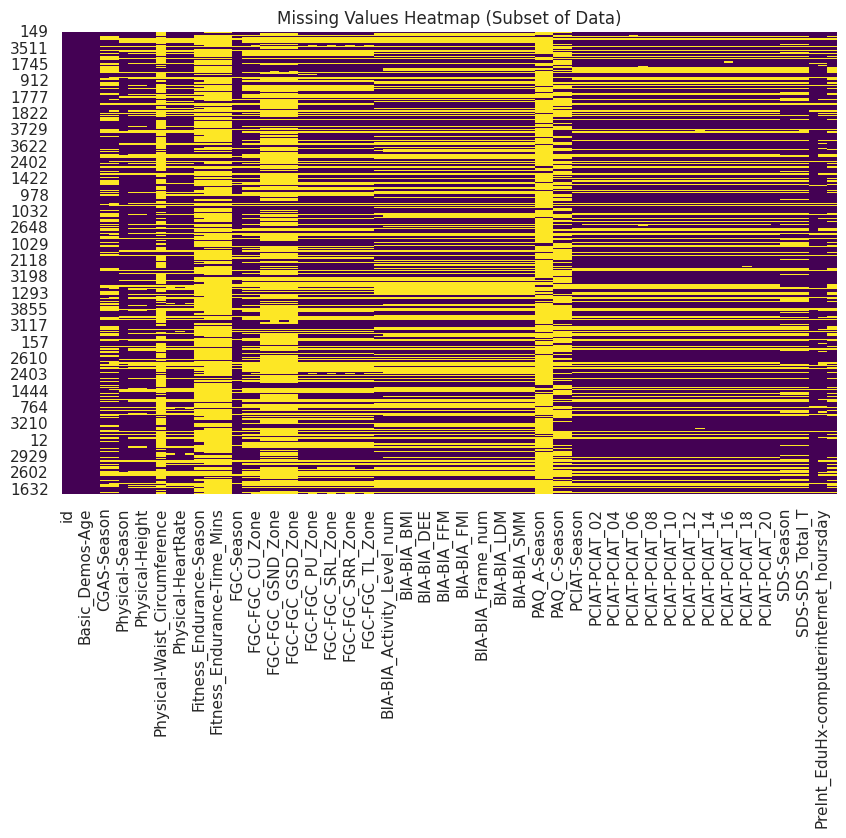

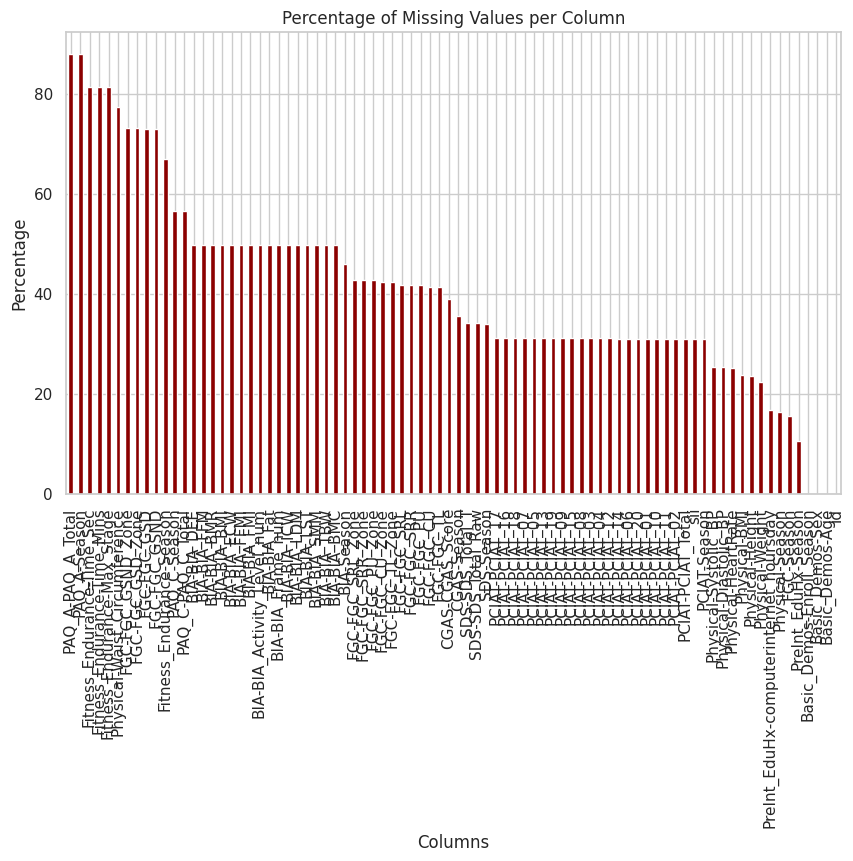

In [26]:
# Visualize missing values using a heatmap for a subset of the dataset
# 1. Filter for a smaller sample of rows or columns
sampled_data = train.sample(frac=0.1, random_state=42)  # 10% random sample of rows
# Or you can use just a subset of columns:
# sampled_data = train[['column1', 'column2', 'column3', ...]]

# 2. Plot missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sampled_data.isnull(), cbar=False, cmap="viridis", cbar_kws={'label': 'Missing Data'})
plt.title("Missing Values Heatmap (Subset of Data)")
plt.show()

# 3. Alternatively, visualize the percentage of missing data per column
missing_percentage = train.isnull().mean() * 100
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Plot the missing data percentages
plt.figure(figsize=(10, 6))
missing_percentage_sorted.plot(kind='bar', color='darkred')
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.show()


<Figure size 1000x600 with 0 Axes>

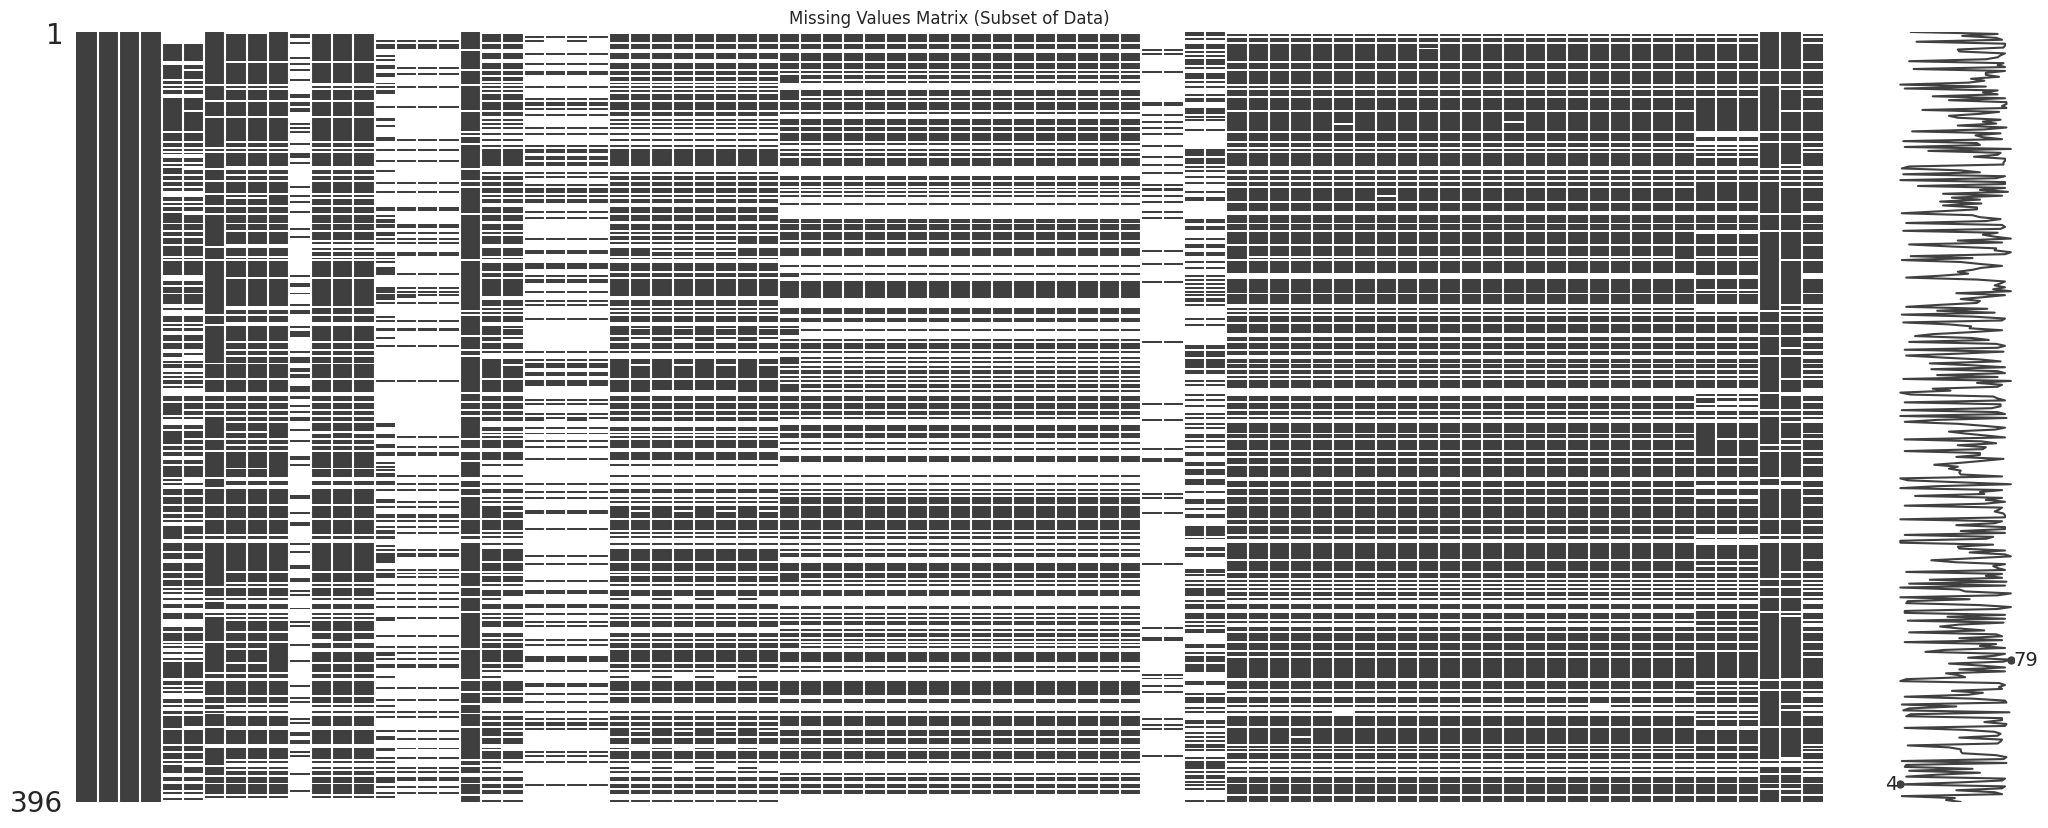

In [28]:
import missingno as msno

# Visualize missing values with a matrix plot using missingno
plt.figure(figsize=(10, 6))
msno.matrix(train.sample(frac=0.1))  # Show 10% of the dataset
plt.title("Missing Values Matrix (Subset of Data)")
plt.show()


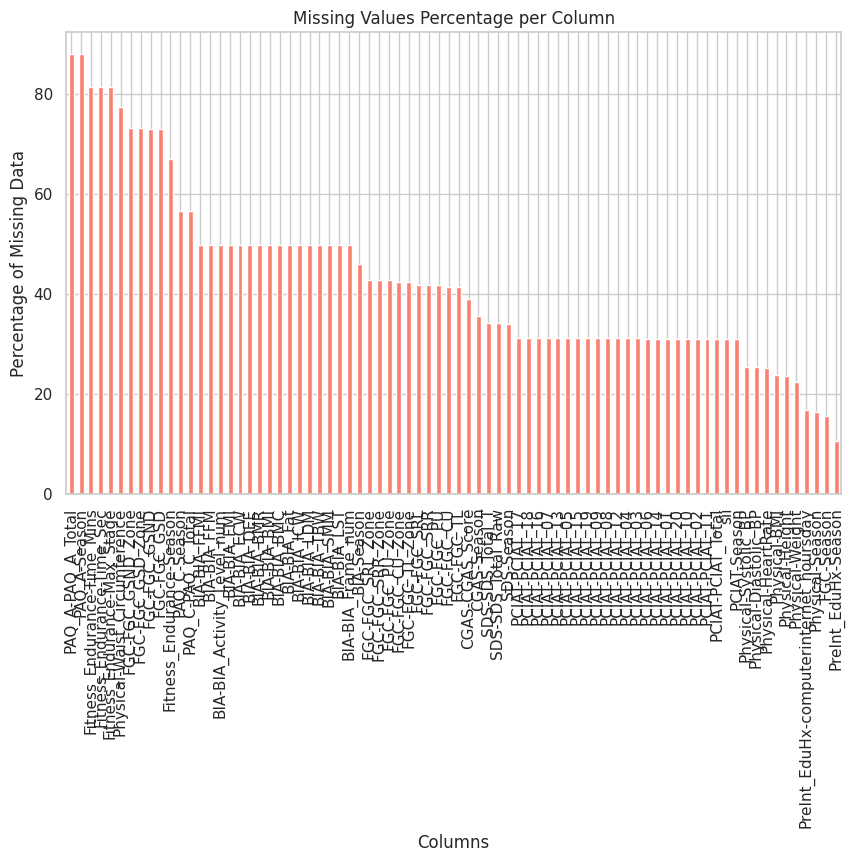

In [29]:
# Calculate percentage of missing values per column
missing_percentage = train.isnull().mean() * 100

# Sort and plot the missing percentage
plt.figure(figsize=(10, 6))
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title("Missing Values Percentage per Column")
plt.ylabel("Percentage of Missing Data")
plt.xlabel("Columns")
plt.show()


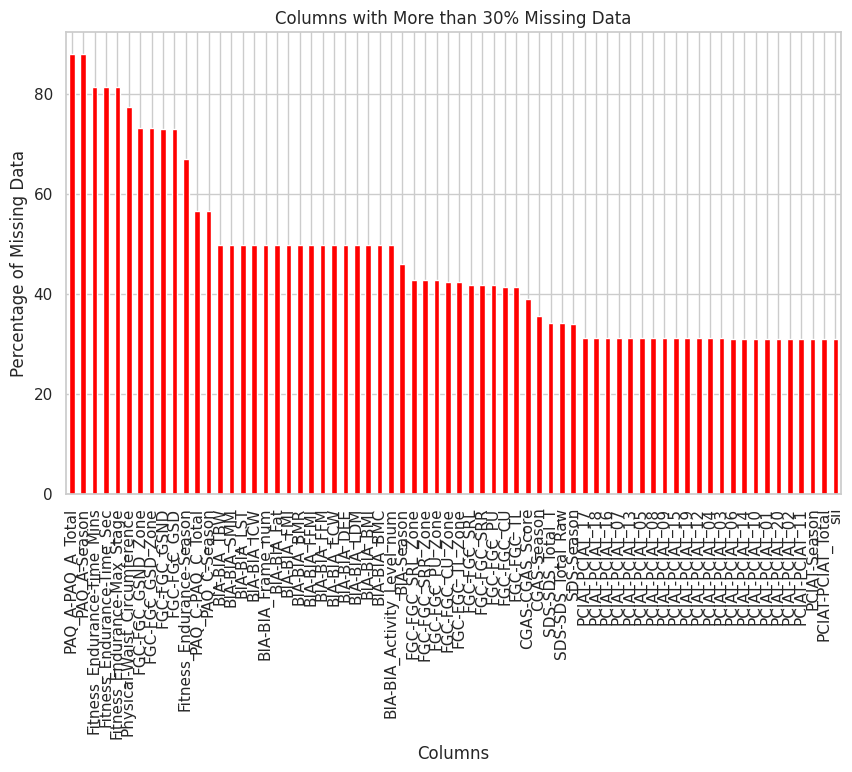

In [30]:
# Identify columns with more than 30% missing data
high_missing_columns = missing_percentage[missing_percentage > 30]

# Plot the columns with high missing data
plt.figure(figsize=(10, 6))
high_missing_columns.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title("Columns with More than 30% Missing Data")
plt.ylabel("Percentage of Missing Data")
plt.xlabel("Columns")
plt.show()


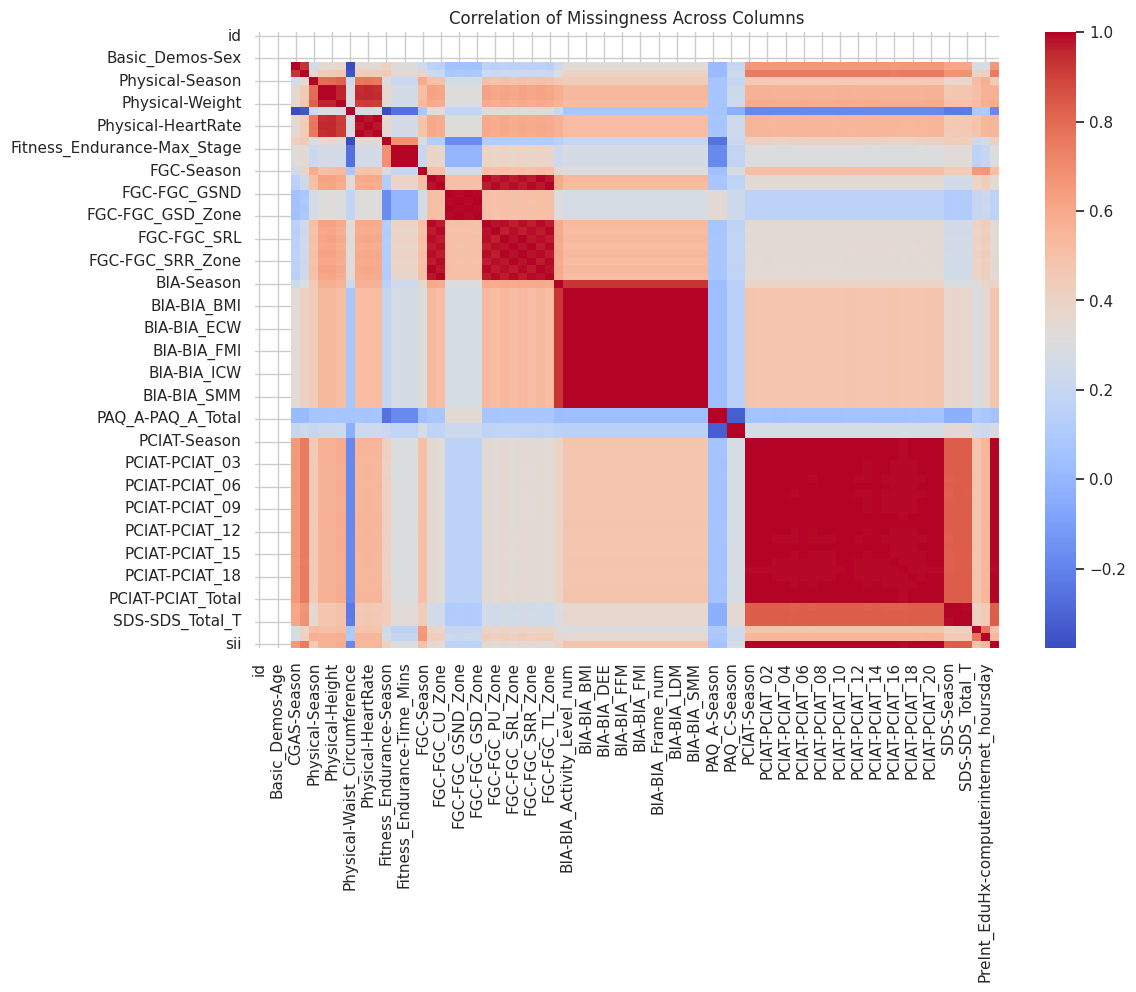

In [31]:
# Correlation of missing data between columns
missing_data_corr = train.isnull().astype(int).corr()

# Plot the correlation matrix of missingness
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data_corr, cmap='coolwarm', annot=False, fmt='.2f', cbar=True)
plt.title("Correlation of Missingness Across Columns")
plt.show()


In [32]:
# Summary table of missing data
missing_summary = train.isnull().sum().sort_values(ascending=False)
missing_percentage = (train.isnull().mean() * 100).sort_values(ascending=False)

missing_data_overview = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage Missing': missing_percentage
})

# Display the missing data overview
missing_data_overview = missing_data_overview[missing_data_overview['Missing Values'] > 0]
print(missing_data_overview.head(20))  # Display top 20 columns with missing data


                              Missing Values  Percentage Missing
PAQ_A-PAQ_A_Total                       3485           88.005051
PAQ_A-Season                            3485           88.005051
Fitness_Endurance-Time_Sec              3220           81.313131
Fitness_Endurance-Time_Mins             3220           81.313131
Fitness_Endurance-Max_Stage             3217           81.237374
Physical-Waist_Circumference            3062           77.323232
FGC-FGC_GSND_Zone                       2898           73.181818
FGC-FGC_GSD_Zone                        2897           73.156566
FGC-FGC_GSD                             2886           72.878788
FGC-FGC_GSND                            2886           72.878788
Fitness_Endurance-Season                2652           66.969697
PAQ_C-Season                            2239           56.540404
PAQ_C-PAQ_C_Total                       2239           56.540404
BIA-BIA_DEE                             1969           49.722222
BIA-BIA_FFM              

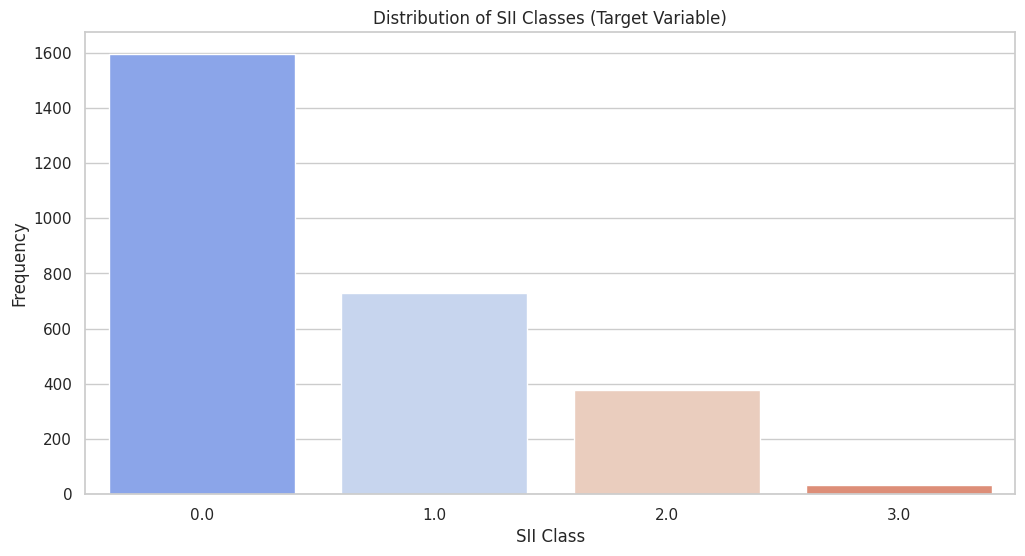

In [9]:
# Visualize target variable distribution
sns.countplot(data=train, x="sii", palette="coolwarm")
plt.title("Distribution of SII Classes (Target Variable)")
plt.xlabel("SII Class")
plt.ylabel("Frequency")
plt.show()

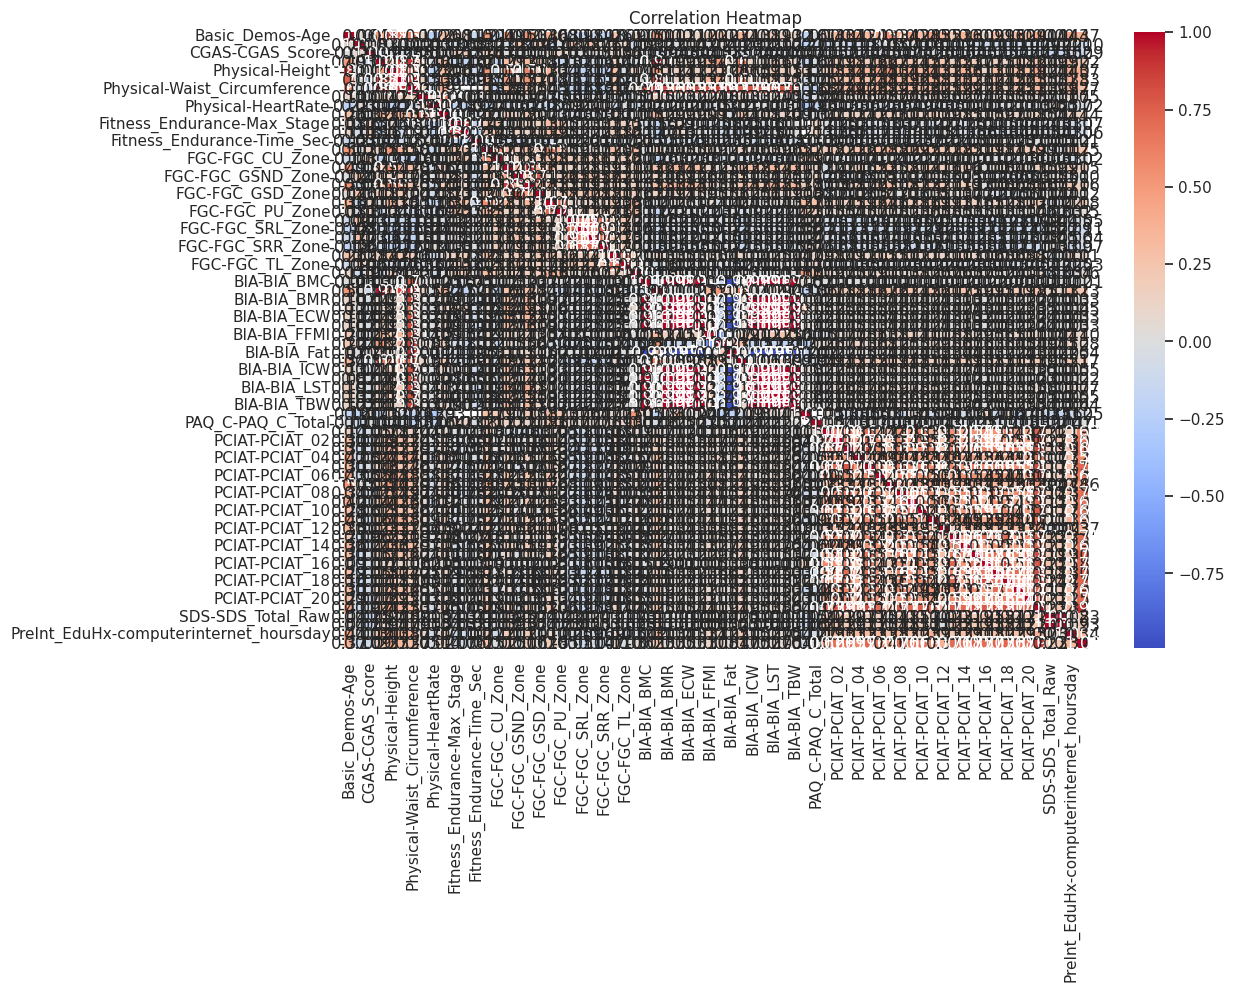

In [11]:
# Correlation heatmap for numeric features
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(12, 8))
corr_matrix = train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Ya que hay muchos datos cambiamos el heatmap

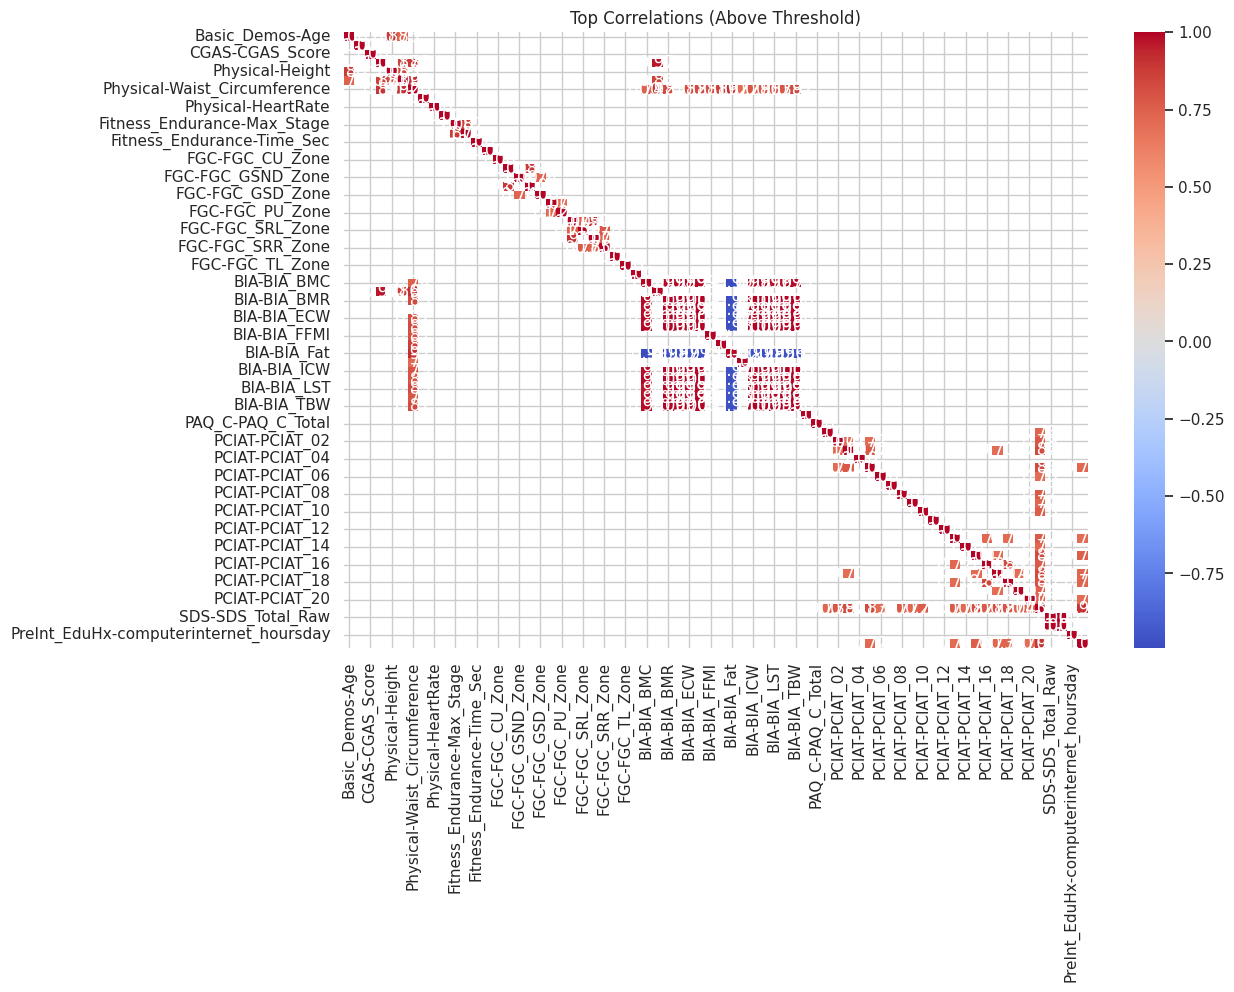

In [22]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Correlation heatmap for numeric features with reduced dimensions
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns
corr_matrix = train[numeric_cols].corr()

# Define the threshold to filter top correlations
threshold = 0.7  # You can adjust this threshold based on your needs

# Filter the correlation matrix to show only correlations above the threshold
top_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top Correlations (Above Threshold)")
plt.show()


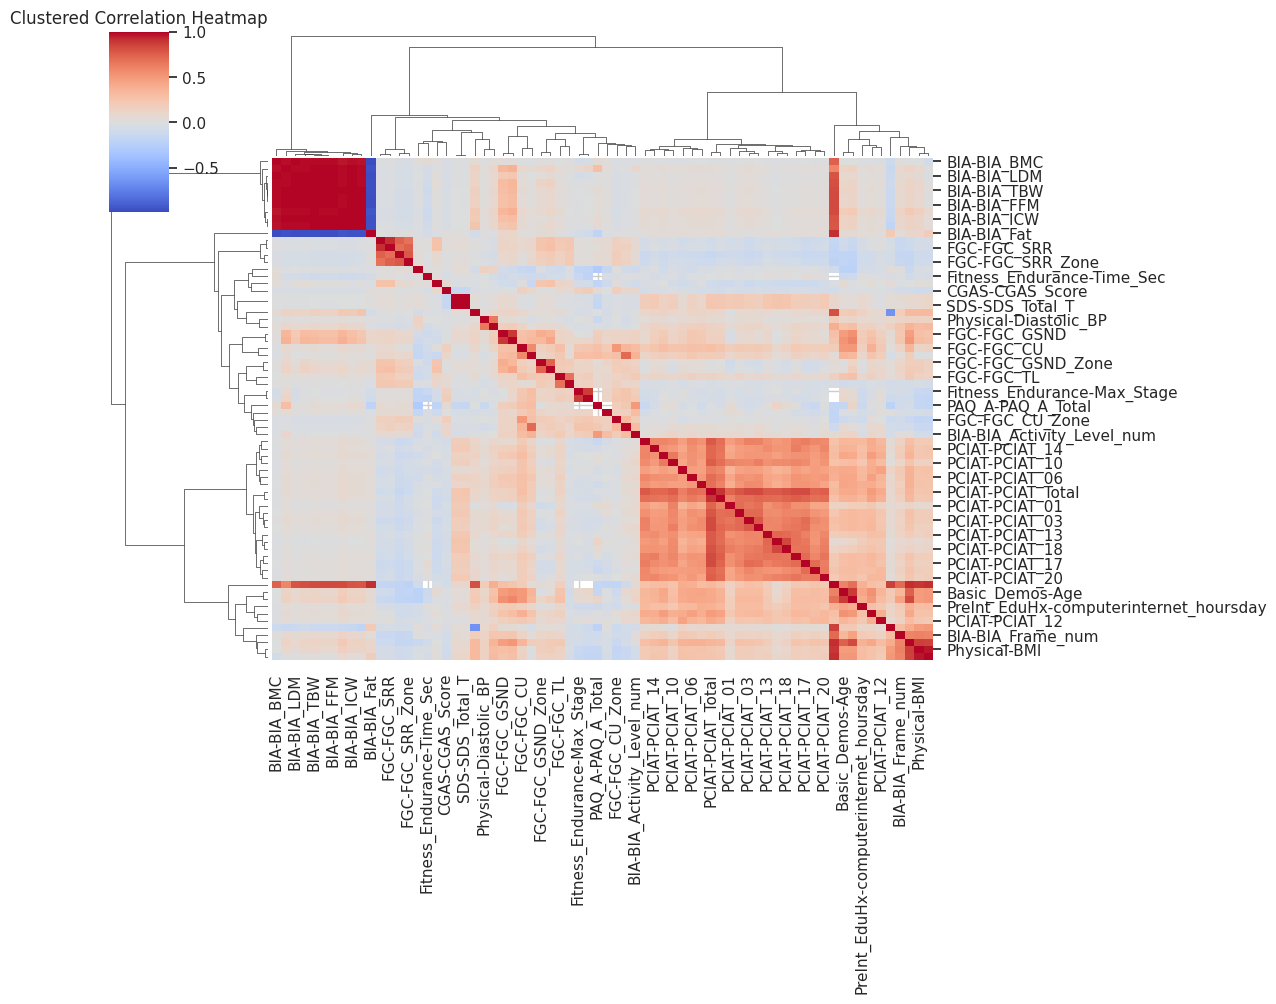

In [24]:
from scipy.cluster.hierarchy import linkage
#import seaborn as sns
#import matplotlib.pyplot as plt

# Correlation heatmap for numeric features with clustering
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns
corr_matrix = train[numeric_cols].corr()

# Perform hierarchical clustering on the correlation matrix
linkage_matrix = linkage(corr_matrix.fillna(0), method="ward")

# Plot the clustered heatmap
sns.clustermap(
    corr_matrix,
    annot=False,  # Set to True if you want annotations
    fmt=".2f",
    cmap="coolwarm",
    figsize=(12, 10),
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
)
plt.title("Clustered Correlation Heatmap")
plt.show()


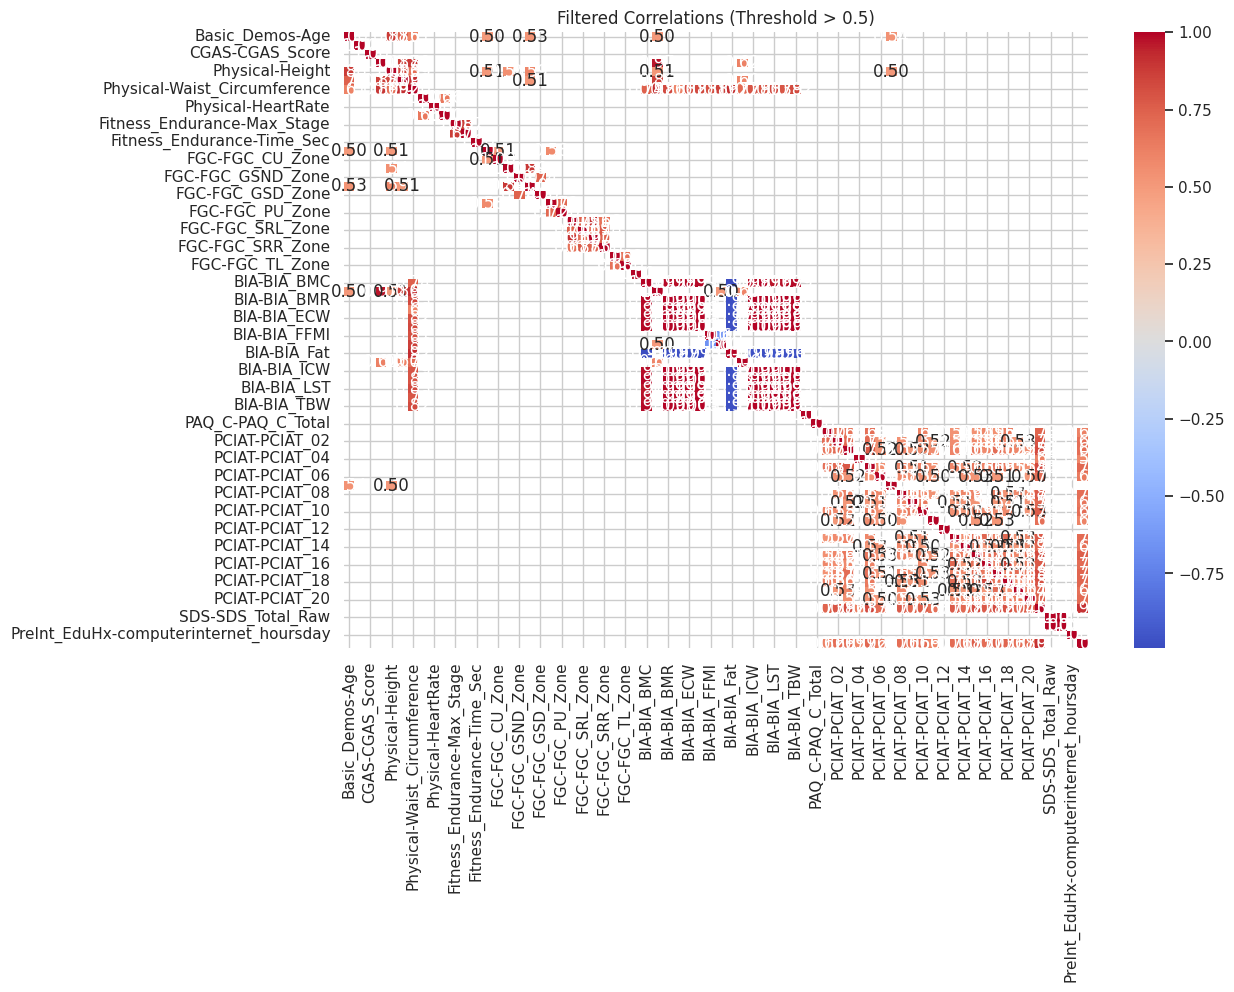

In [25]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Correlation heatmap for numeric features with filtering based on threshold
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns
corr_matrix = train[numeric_cols].corr()

# Define the threshold for filtering
threshold = 0.5  # You can change this threshold value as needed

# Filter the correlations based on the threshold
filtered_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Filtered Correlations (Threshold > {threshold})")
plt.show()


In [12]:
# Check skewness and kurtosis of numeric features
for col in numeric_cols:
    print(f"{col}: Skewness = {skew(train[col].dropna()):.2f}, Kurtosis = {kurtosis(train[col].dropna()):.2f}")


Basic_Demos-Age: Skewness = 0.72, Kurtosis = -0.07
Basic_Demos-Sex: Skewness = 0.53, Kurtosis = -1.72
CGAS-CGAS_Score: Skewness = 30.12, Kurtosis = 1257.37
Physical-BMI: Skewness = 1.63, Kurtosis = 5.24
Physical-Height: Skewness = 0.26, Kurtosis = -0.69
Physical-Weight: Skewness = 1.18, Kurtosis = 2.06
Physical-Waist_Circumference: Skewness = 1.24, Kurtosis = 1.76
Physical-Diastolic_BP: Skewness = 1.20, Kurtosis = 4.60
Physical-HeartRate: Skewness = 0.26, Kurtosis = 0.35
Physical-Systolic_BP: Skewness = 0.83, Kurtosis = 3.13
Fitness_Endurance-Max_Stage: Skewness = 3.54, Kurtosis = 38.07
Fitness_Endurance-Time_Mins: Skewness = 0.08, Kurtosis = 1.10
Fitness_Endurance-Time_Sec: Skewness = 0.02, Kurtosis = -1.16
FGC-FGC_CU: Skewness = 2.15, Kurtosis = 8.27
FGC-FGC_CU_Zone: Skewness = 0.09, Kurtosis = -1.99
FGC-FGC_GSND: Skewness = 2.42, Kurtosis = 12.97
FGC-FGC_GSND_Zone: Skewness = 0.11, Kurtosis = -0.47
FGC-FGC_GSD: Skewness = 2.24, Kurtosis = 11.13
FGC-FGC_GSD_Zone: Skewness = 0.06, Kur

In [13]:
# Handling missing data using KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_imputed = pd.DataFrame(imputer.fit_transform(train[numeric_cols]), columns=numeric_cols)
print("\nMissing Values After Imputation:")
print(train_imputed.isnull().sum())



Missing Values After Imputation:
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-CGAS_Score                           0
Physical-BMI                              0
Physical-Height                           0
                                         ..
PCIAT-PCIAT_Total                         0
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
Length: 70, dtype: int64


In [15]:
# Load Parquet files (example for one file)
parquet_file = "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet"  # Update with the actual file path
actigraphy_data = pd.read_parquet(parquet_file)
print(actigraphy_data.head())


   step         X         Y         Z      enmo     anglez  non-wear_flag  \
0     0  0.021536  0.022214 -1.022370  0.022853 -88.280762            0.0   
1     1  0.022005  0.022187 -1.019740  0.020231 -88.241707            0.0   
2     2  0.022240  0.022005 -1.019401  0.019893 -88.170067            0.0   
3     3  0.021589  0.022578 -1.018177  0.018667 -88.250031            0.0   
4     4  0.022005  0.023763 -1.014323  0.016848 -88.130775            0.0   

       light  battery_voltage     time_of_day  weekday  quarter  \
0  53.000000      4188.000000  56940000000000        4        3   
1  51.666668      4188.166504  56945000000000        4        3   
2  50.333332      4188.333496  56950000000000        4        3   
3  50.500000      4188.500000  56955000000000        4        3   
4  33.166668      4181.000000  57235000000000        4        3   

   relative_date_PCIAT  
0                 41.0  
1                 41.0  
2                 41.0  
3                 41.0  
4        

In [16]:
# Compute descriptive statistics for actigraphy data
actigraphy_summary = actigraphy_data.describe()
print("\nActigraphy Data Summary:")
print(actigraphy_summary)


Actigraphy Data Summary:
               step             X             Y             Z          enmo  \
count  43330.000000  43330.000000  43330.000000  43330.000000  43330.000000   
mean   21664.500000     -0.316384      0.016009     -0.167890      0.047388   
std    12508.437919      0.453665      0.502702      0.585710      0.106351   
min        0.000000     -1.746094     -2.905339     -1.048372      0.000000   
25%    10832.250000     -0.684180     -0.309863     -0.649974      0.006432   
50%    21664.500000     -0.366849      0.024974     -0.245378      0.023637   
75%    32496.750000     -0.010677      0.400677      0.204727      0.041420   
max    43329.000000      1.507865      1.666354      1.546979      4.004276   

             anglez  non-wear_flag         light  battery_voltage  \
count  43330.000000        43330.0  43330.000000     43330.000000   
mean     -10.580416            0.0     42.296310      4053.579102   
std       42.947170            0.0    208.168976       

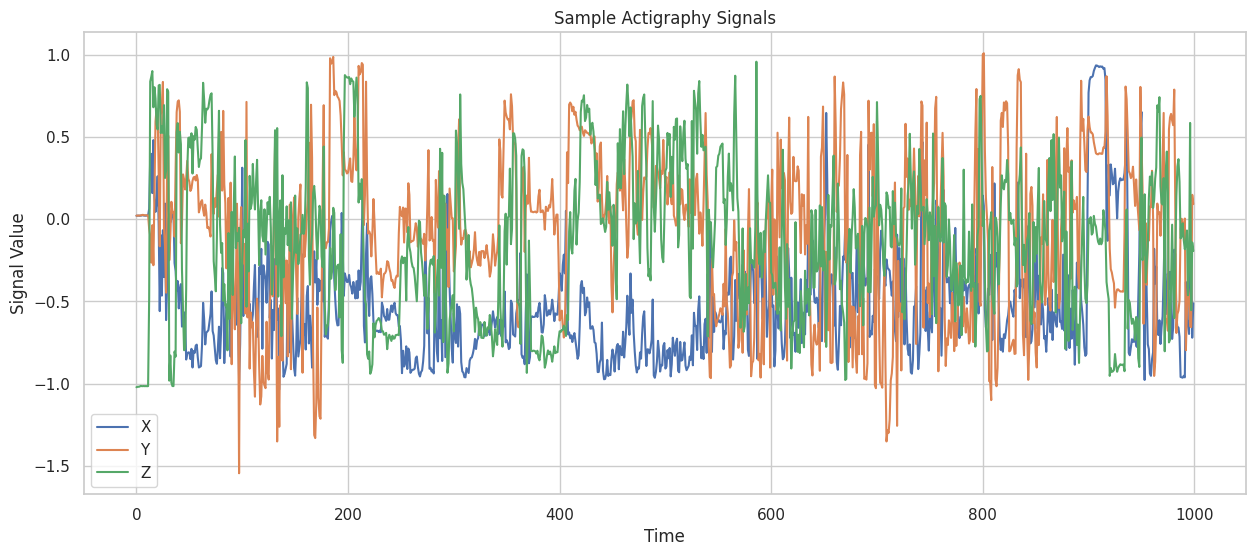

In [17]:
# Time series visualization for actigraphy data (example for one signal)
plt.figure(figsize=(15, 6))
plt.plot(actigraphy_data["X"][:1000], label="X")
plt.plot(actigraphy_data["Y"][:1000], label="Y")
plt.plot(actigraphy_data["Z"][:1000], label="Z")
plt.title("Sample Actigraphy Signals")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

In [19]:
print(actigraphy_data.columns)


Index(['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
       'battery_voltage', 'time_of_day', 'weekday', 'quarter',
       'relative_date_PCIAT'],
      dtype='object')


In [20]:
# Aggregate actigraphy features by day
actigraphy_data['date'] = pd.to_datetime(actigraphy_data['weekday']).dt.date
daily_summary = actigraphy_data.groupby('date').agg({
    'enmo': ['mean', 'std', 'max'],
    'anglez': ['mean', 'std', 'max']
}).reset_index()
daily_summary.columns = ['date', 'enmo_mean', 'enmo_std', 'enmo_max', 'anglez_mean', 'anglez_std', 'anglez_max']
print("\nDaily Aggregated Summary:")
print(daily_summary.head())


Daily Aggregated Summary:
         date  enmo_mean  enmo_std  enmo_max  anglez_mean  anglez_std  \
0  1970-01-01   0.047388  0.106351  4.004276   -10.580416    42.94717   

   anglez_max  
0   89.751656  


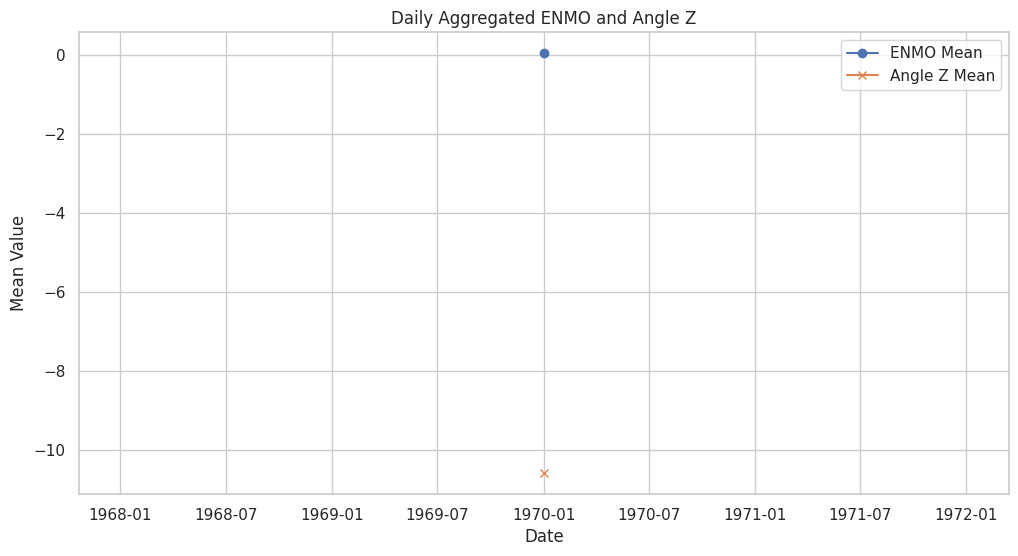

In [21]:
# Visualize daily aggregated data
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['enmo_mean'], label='ENMO Mean', marker='o')
plt.plot(daily_summary['date'], daily_summary['anglez_mean'], label='Angle Z Mean', marker='x')
plt.title("Daily Aggregated ENMO and Angle Z")
plt.xlabel("Date")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

In [ ]:
# Save processed train set
train_imputed.to_csv("processed_train.csv", index=False)